In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications import ResNet50V2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
# Load cifar10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
x_train = tf.image.resize(x_train, (64, 64))
x_test = tf.image.resize(x_test, (64, 64))

I0000 00:00:1760805192.111752      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760805192.112462      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
# Preprocess the data
x_train = tf.keras.applications.resnet.preprocess_input(x_train)
x_test = tf.keras.applications.resnet.preprocess_input(x_test)

In [5]:
# Data augnentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomRotation(0.1),
])

In [8]:
# Load the ResNet50V2 model without the top layer
res_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
res_model.trainable = True

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Add custom top layers

inputs = tf.keras.Input(shape=(64,64,3))
x = data_augmentation(inputs)

x = res_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# Final model
model = tf.keras.Model(inputs=inputs, outputs=predictions)

In [13]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
    )

es = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

In [14]:
history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[es, lr]
)

Epoch 1/30


I0000 00:00:1760805664.135337      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


782/782 ━━━━━━━━━━━━━━━━━━━━ 150s 128ms/step - accuracy: 0.4113 - loss: 1.7145 - val_accuracy: 0.2061 - val_loss: 3.2915 - learning_rate: 0.0010
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 121ms/step - accuracy: 0.5433 - loss: 1.3243 - val_accuracy: 0.6620 - val_loss: 1.0181 - learning_rate: 0.0010
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 120ms/step - accuracy: 0.6422 - loss: 1.0667 - val_accuracy: 0.7343 - val_loss: 0.7955 - learning_rate: 0.0010
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 121ms/step - accuracy: 0.6963 - loss: 0.8989 - val_accuracy: 0.7159 - val_loss: 0.9052 - learning_rate: 0.0010
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 121ms/step - accuracy: 0.7139 - loss: 0.8501 - val_accuracy: 0.7364 - val_loss: 0.8379 - learning_rate: 0.0010
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 120ms/step - accuracy: 0.7460 - loss: 0.7571 - val_accuracy: 0.7553 - val_loss: 0.7418 - learning_rate: 0.0010
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 121ms/step - accuracy: 0.7579 - loss

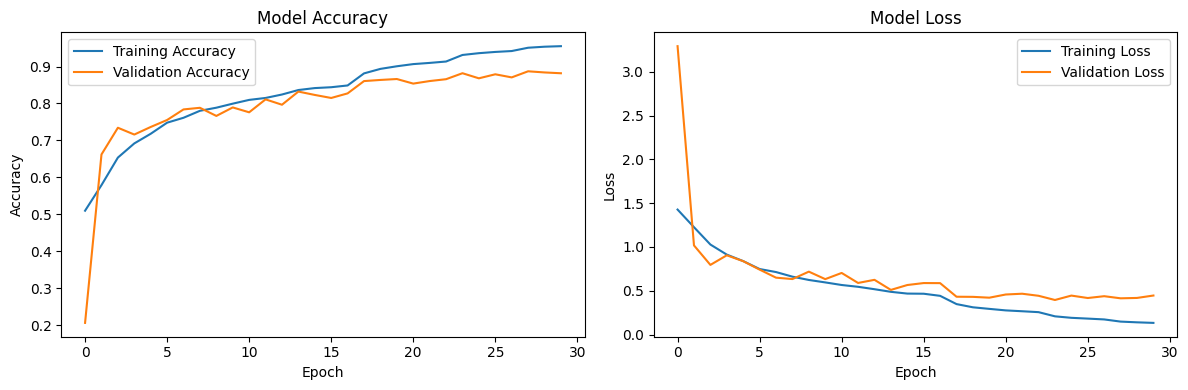

In [16]:
# Plot training & validation accuracy, loss values
history = model.history.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy values
ax1.plot(history['accuracy'], label='Training Accuracy')
ax1.plot(history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot training & validation loss values
ax2.plot(history['loss'], label='Training Loss')
ax2.plot(history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.savefig('/kaggle/working/accuracy_loss_plot.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [25]:
# Retrieve best metrics
best_train_acc = max(history['accuracy'])
best_val_acc = max(history['val_accuracy'])
print(f"Best training accuracy is {(best_train_acc * 100):.2f}%")
print(f"Best validation accuracy is {(best_val_acc * 100):.2f}%")

Best training accuracy is 95.51%
Best validation accuracy is 88.71%
